In [26]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml
import matplotlib.dates as mdates
import os
import numpy as np
import yfinance as yf
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker


# Adjust pandas settings to display all columns
pd.set_option('display.max_columns', None)


In [27]:

def plot_seasonal_trends(pivot_dataset, chart_name, chart_title):
    # Path to your Montserrat font (update the path to where you have the font file)
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'  # Adjust the font path as needed
    font_prop = fm.FontProperties(fname=font_path)
    
    # Set the font globally for the plot
    plt.rcParams['font.family'] = font_prop.get_name()  # Correctly apply the font name

    # Remove Week 1 and Week 53
    plot_data = pivot_dataset[(pivot_dataset.index != 1) & (pivot_dataset.index != 53)]

    # Ensure plot_data is sorted by index (Week)
    plot_data = plot_data.sort_index()

    # Create a numerical range for the x-axis based on the length of the DataFrame
    x_values = np.arange(len(plot_data))

    # Set up the figure size for 60% of A4 landscape dimensions
    plt.figure(figsize=(7, 5))  # 60% of A4 landscape size

    # Plot the 5-Year Max/Min range as a shaded area
    plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

    # Colors
    fiveYear_avgColor = "black"
    fiveYear_2023Color = "#FFA500"
    fiveYear_2024Color = "#003366"

    # Plot the 5-Year Average
    plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)

    # Plot the 2023 values
    plt.plot(plot_data.index, plot_data[2023], color=fiveYear_2023Color, label='2023', linewidth=1.5, alpha=0.7)

    # Plot the 2024 values
    plt.plot(plot_data.index, plot_data[2024], color=fiveYear_2024Color, marker='o', label='2024', linewidth=2)

    # Improve the y-axis to show values in the format '10.000', '20.000', etc.
    def thousands(x, pos):
        """Format the y-axis values with a dot as the thousand separator."""
        return f'{int(x / 1000):,}'.replace(',', '.')  # Format as '10.000', '20.000', etc.

    # Set the y-axis formatter
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
    
    y_label = "Thousand Barrels"
    
    # Customize the plot
    plt.title(f"{chart_title}", fontsize=16, fontweight='bold')
    plt.xlabel("Week", fontsize=12, fontweight='bold')
    plt.ylabel(f"{y_label}", fontsize=12, fontweight='bold')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as a PNG file in the specified export path
    export_path = "../report/images/"
    export_file_name = chart_name.replace(" ", "_") + ".png"
    export_file_path = os.path.join(export_path, export_file_name)
    plt.savefig(export_file_path, bbox_inches='tight')

    # Show the plot
    plt.show()

# Export Pivot Data
def pivot_dataset(dataset, date_pos, data_position, exportFileName):
    
    # Select the columns by position
    df = dataset.iloc[:, [date_pos, data_position]].copy()
    
    # Rename the columns for easier access
    df.columns = ['Date', 'Data']
    
    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract week number, month, and year
    df['Week_Num'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    
    # df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
    pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
    
    # Sort the columns to have years starting from the newest
    pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)
    
    # Define the export path
    export_folder = "../data/processed/"
    export_file = export_folder + f"{exportFileName}.parquet"
    
    # Export the pivoted DataFrame to Parquet format
    pivoted_df.to_parquet(export_file)

    print("Success processed: " + dataset.columns[data_position])

def calculate_5_year_metrics(df):
    """
    This function calculates the 5-year maximum, minimum, and average for each row
    excluding the first column in the provided DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with at least 6 columns.
    
    Returns:
    pd.DataFrame: The DataFrame with 5YrMax, 5YrMin, and 5YrAvg columns added.
    """
    
    # Select the columns from the second to the sixth (excluding the first column)
    df = df.iloc[:,0:6]
    fiveYearsRange = df.iloc[:, 1:6]
    
    # Calculate the 5-year max, min, and average for each row
    df["5YrMax"] = fiveYearsRange.max(axis=1)
    df["5YrMin"] = fiveYearsRange.min(axis=1)
    df["5YrAvg"] = fiveYearsRange.mean(axis=1)
    
    return df

In [28]:
# Global Settings and Import Data

# folder with raw data
raw_path_data = "../data/raw/PET_STOC_WSTK_DCU_NUS_W.xls"

# importing all crude oil and products inventories
oil_stock_data = pd.read_excel(raw_path_data, sheet_name="Data 1", skiprows=2)

In [29]:
def calculate_stock_changes(df):
    
    stock_changes = df.diff().iloc[-1]
    
    yaml_data = {
        "all_petroleum_products_chg": round(float(stock_changes.iloc[1])/1000, 3),
        "oil_commercial_stocks_chg": round(float(stock_changes.iloc[4])/1000, 3),
        "m_gasoline_stocks_chg": round(float(stock_changes.iloc[8])/1000, 3),
        "m_distillate_stocks_chg": round(float(stock_changes.iloc[26])/1000, 3),
    }

    # Save as YAML
    with open("../data/page_layout.yaml", "w") as file:
        yaml.dump(yaml_data, file, default_flow_style=False)

    
    print(stock_changes.iloc[[1,4,8,26]])

calculate_stock_changes(oil_stock_data)

Weekly U.S. Ending Stocks of Crude Oil and Petroleum Products  (Thousand Barrels)   -5908.0
Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)             2089.0
Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)                     -4407.0
Weekly U.S. Ending Stocks of Distillate Fuel Oil  (Thousand Barrels)                -1394.0
Name: 2197, dtype: object


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Success processed: Weekly U.S. Ending Stocks of Crude Oil and Petroleum Products  (Thousand Barrels)


findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

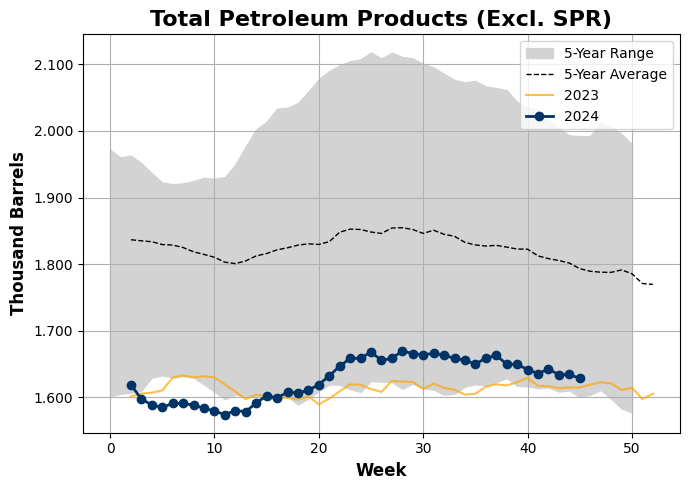

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Success processed: Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)


findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

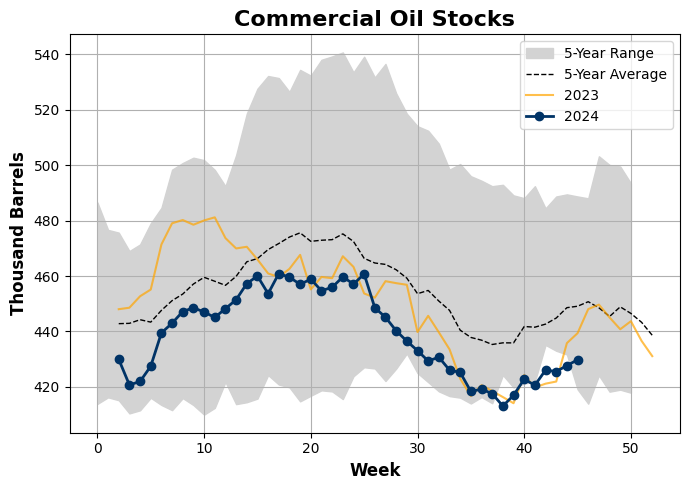

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Success processed: Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)


findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

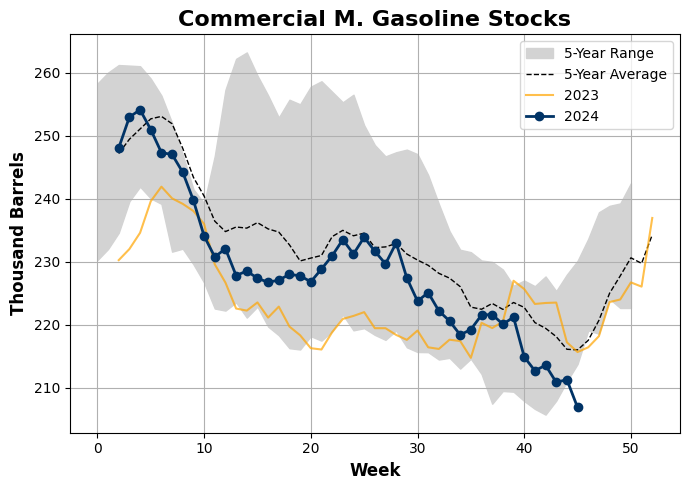

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_36516/911104275.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Success processed: Weekly U.S. Ending Stocks of Distillate Fuel Oil  (Thousand Barrels)


findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

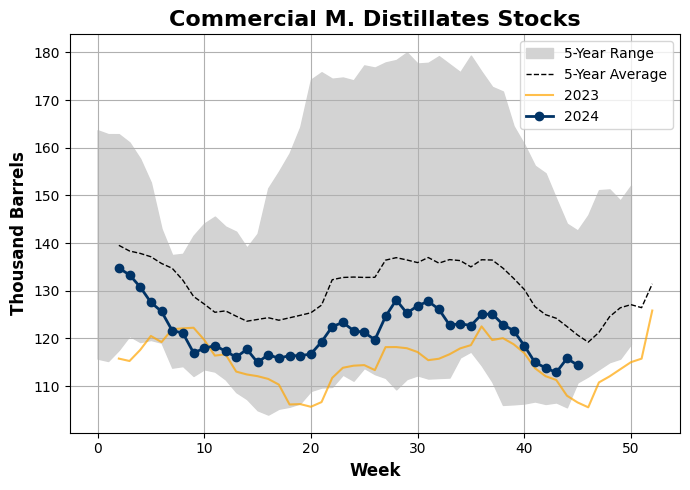

In [30]:
# Preparing Charts and Data

# Total Petroleum Products - Pivoting, Importing Parque Data for Total Oil Products and Preparing Chart
data_reference = "all_petroleum_products"
data_name = "Total Petroleum Products (Excl. SPR)"
pivot_dataset(oil_stock_data, 0, 1, data_reference)
total_oil_pivot_data = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
total_oil_pivot_data = calculate_5_year_metrics(total_oil_pivot_data)
plot_seasonal_trends(total_oil_pivot_data, data_reference , data_name)

# Commercial Oil Stocks - Pivoting, Importing Parque Data for Total Oil Products and Preparing Chart
data_reference = "oil_commercial_stocks"
data_name = "Commercial Oil Stocks"
pivot_dataset(oil_stock_data, 0, 4, data_reference)
total_oil_pivot_data = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
total_oil_pivot_data = calculate_5_year_metrics(total_oil_pivot_data)
plot_seasonal_trends(total_oil_pivot_data, data_reference , data_name)

# Commercial Oil Stocks - Pivoting, Importing Parque Data for Total Oil Products and Preparing Chart
data_reference = "m_gasoline_stocks"
data_name = "Commercial M. Gasoline Stocks"
pivot_dataset(oil_stock_data, 0, 8, data_reference)
total_oil_pivot_data = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
total_oil_pivot_data = calculate_5_year_metrics(total_oil_pivot_data)
plot_seasonal_trends(total_oil_pivot_data, data_reference , data_name)

# Commercial Oil Stocks - Pivoting, Importing Parque Data for Total Oil Products and Preparing Chart
data_reference = "m_distillate_stocks"
data_name = "Commercial M. Distillates Stocks"
pivot_dataset(oil_stock_data, 0, 26, data_reference)
total_oil_pivot_data = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
total_oil_pivot_data = calculate_5_year_metrics(total_oil_pivot_data)
plot_seasonal_trends(total_oil_pivot_data, data_reference , data_name)